In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [ ]:
cd ..

/


In [4]:
!cp '/content/drive/MyDrive/Colab Notebooks/newdata.zip' content

In [5]:
 cd content

/content


In [6]:
!unzip newdata.zip -d newdata

Archive:  newdata.zip
  inflating: newdata/Potato/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG  
  inflating: newdata/Potato/Potato___Early_blight/002a55fb-7a3d-4a3a-aca8-ce2d5ebc6925___RS_Early.B 8170.JPG  
  inflating: newdata/Potato/Potato___Early_blight/009c8c31-f22d-4ffd-8f16-189c6f06c577___RS_Early.B 7885.JPG  
  inflating: newdata/Potato/Potato___Early_blight/00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG  
  inflating: newdata/Potato/Potato___Early_blight/0182e991-97f0-4805-a1f7-6e1b4306d518___RS_Early.B 7015.JPG  
  inflating: newdata/Potato/Potato___Early_blight/02578b86-b234-4ac0-9bc3-691b5610e2bf___RS_Early.B 7562.JPG  
  inflating: newdata/Potato/Potato___Early_blight/0267d4ca-522e-4ca0-b1a2-ce925e5b54a2___RS_Early.B 7020.JPG  
  inflating: newdata/Potato/Potato___Early_blight/028f9b73-142f-499a-9c7b-d7c1ed5e5506___RS_Early.B 8546.JPG  
  inflating: newdata/Potato/Potato___Early_blight/034959c1-f1e8-4a79-a6d5-3c1d14efa2f3___R

In [7]:
cd newdata

/content/newdata


In [10]:
directory="Potato/"
import tensorflow as tf
dataset=tf.keras.utils.image_dataset_from_directory(
    directory,
    shuffle= True,
    batch_size=32,
    image_size=(256, 256),

)

Found 2152 files belonging to 3 classes.


In [11]:
def get_dataset_partition(ds, train_split=0.7, val_split=0.1, test_split=0.2, shuffle=True, shuffle_size=10000):



    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)  # Fixed variable name

    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size).take(int(test_split * ds_size))
    val_ds = ds.skip(train_size + int(test_split * ds_size)).take(val_size)

    return train_ds, test_ds, val_ds


In [12]:
train_ds, test_ds, val_ds=get_dataset_partition(dataset)

In [13]:
print(len(train_ds)*32,len(test_ds)*32,len(val_ds)*32)

1504 416 192


In [14]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, Model

# Define constants
IMAGE_SIZE = 256  # VGG19 input size
BATCH_SIZE = 32
n_classes = 3

# Load the pre-trained VGG19 model (excluding the top classification layer)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Freeze the weights of the base model
base_model.trainable = False

# Add your custom classification head
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(n_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
# model.summary()


80134624/80134624 [==============================] - 3s 0us/step


In [16]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=101
)

Epoch 1/101
47/47 [==============================] - 11s 88ms/step - loss: 1.5390 - accuracy: 0.7380 - val_loss: 0.1195 - val_accuracy: 0.9375
Epoch 2/101
47/47 [==============================] - 3s 69ms/step - loss: 0.2773 - accuracy: 0.9116 - val_loss: 0.1238 - val_accuracy: 0.9635
Epoch 3/101
47/47 [==============================] - 3s 69ms/step - loss: 0.1665 - accuracy: 0.9362 - val_loss: 0.0676 - val_accuracy: 0.9740
Epoch 4/101
47/47 [==============================] - 3s 69ms/step - loss: 0.1406 - accuracy: 0.9468 - val_loss: 0.0621 - val_accuracy: 0.9792
Epoch 5/101
47/47 [==============================] - 3s 69ms/step - loss: 0.1277 - accuracy: 0.9475 - val_loss: 0.0546 - val_accuracy: 0.9844
Epoch 6/101
47/47 [==============================] - 3s 69ms/step - loss: 0.0912 - accuracy: 0.9648 - val_loss: 0.0400 - val_accuracy: 0.9896
Epoch 7/101
47/47 [==============================] - 3s 69ms/step - loss: 0.0795 - accuracy: 0.9681 - val_loss: 0.0468 - val_accuracy: 0.9844
Epoch

In [33]:
model.save('vggmax.h5')

In [18]:
from tensorflow.keras.models import load_model

In [21]:
model = load_model('/content/newdata/vggmax.h5')

In [22]:
tf.keras.backend.clear_session()
del train_ds
del val_ds

In [23]:
import gc
gc.collect()

456

In [24]:
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
scores=model.evaluate(test_ds)
scores

13/13 [==============================] - 2s 62ms/step - loss: 0.0306 - accuracy: 0.9928


[0.030590197071433067, 0.9927884340286255]

In [26]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
import matplotlib.pyplot as plt
import math

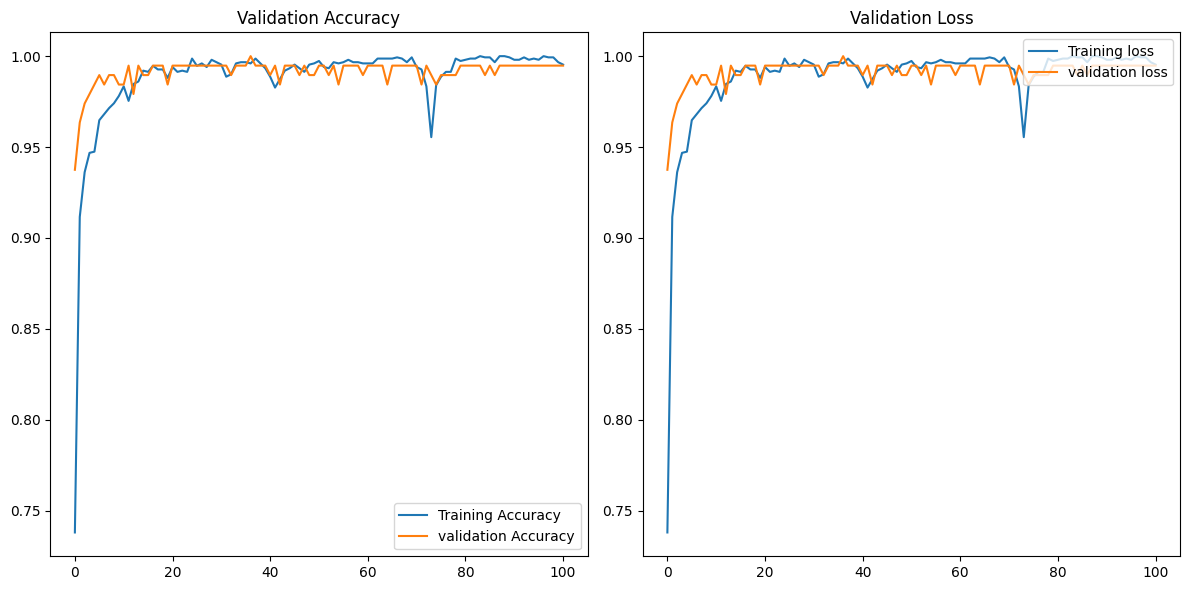

In [27]:
EPOCHS=101
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training')

plt.subplot(1,2,1)
plt.plot(range(EPOCHS),val_acc,label='validation Accuracy')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),acc,label='Training loss')
plt.legend(loc='upper right')
plt.title('Training Loss')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),val_acc,label='validation loss')
plt.legend(loc='upper right')
plt.title('Validation Loss')

plt.tight_layout()
plt.show()

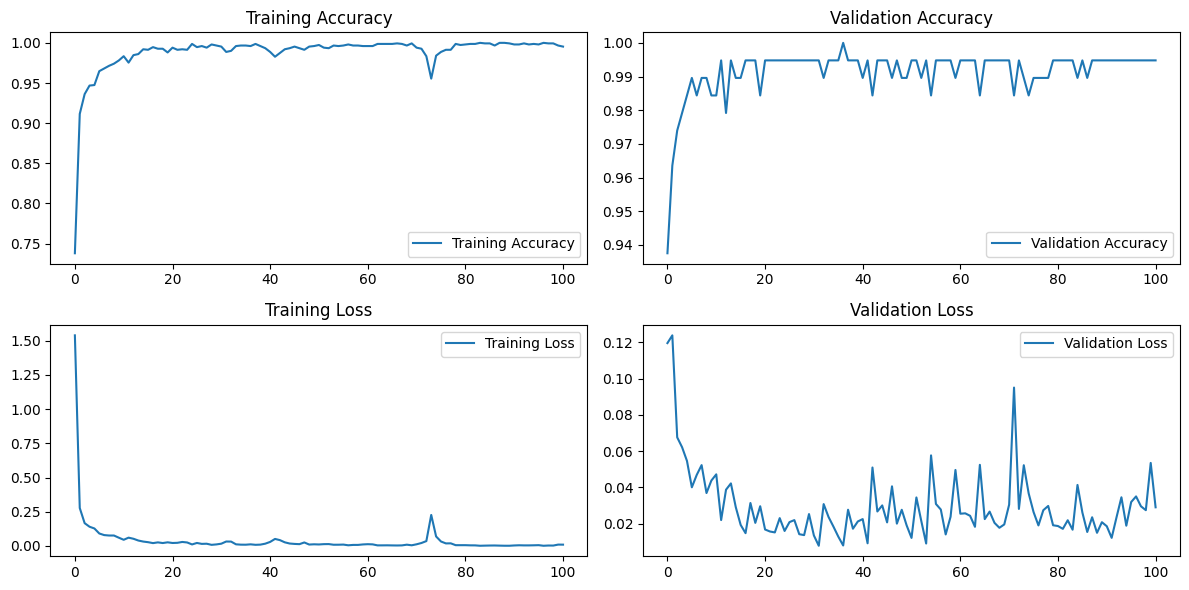

In [28]:
EPOCHS=101
plt.figure(figsize=(12,6))

plt.subplot(2,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(2,2,2)
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')

plt.subplot(2,2,3)
plt.plot(range(EPOCHS), loss, label='Training Loss')  # Changed to 'loss'
plt.legend(loc='upper right')
plt.title('Training Loss')

plt.subplot(2,2,4)
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')  # Changed to 'val_loss'
plt.legend(loc='upper right')
plt.title('Validation Loss')

plt.tight_layout()
plt.show()


In [29]:
import matplotlib.pyplot as plt
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

first image to predict
label:  Potato___Early_blight
1/1 [==============================] - 0s 238ms/step
predicted Label:  Potato___Early_blight


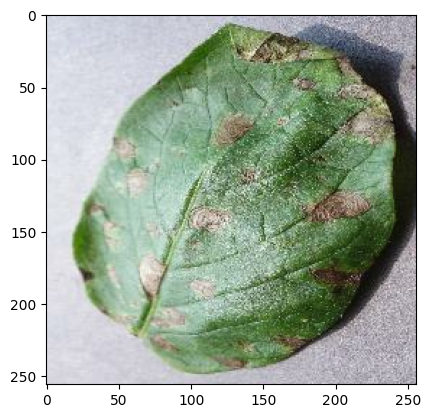

In [30]:
i=5
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

  first_image=images_batch[i].numpy().astype("uint8")

  print("first image to predict")
  plt.imshow(first_image)

  print("label: ", class_names[labels_batch[i].numpy()])
  batch_prediction=model.predict(images_batch)
  print("predicted Label: ",class_names[np.argmax(batch_prediction[i])])

In [31]:
def predict(model, img):
  img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0)

  predictions=model.predict(img_array)
  predicted_class= class_names[np.argmax(predictions[0])]
  confidence=round(100*np.max(predictions[0]),2)
  return predicted_class,confidence

1/1 [==============================] - 0s 24ms/step


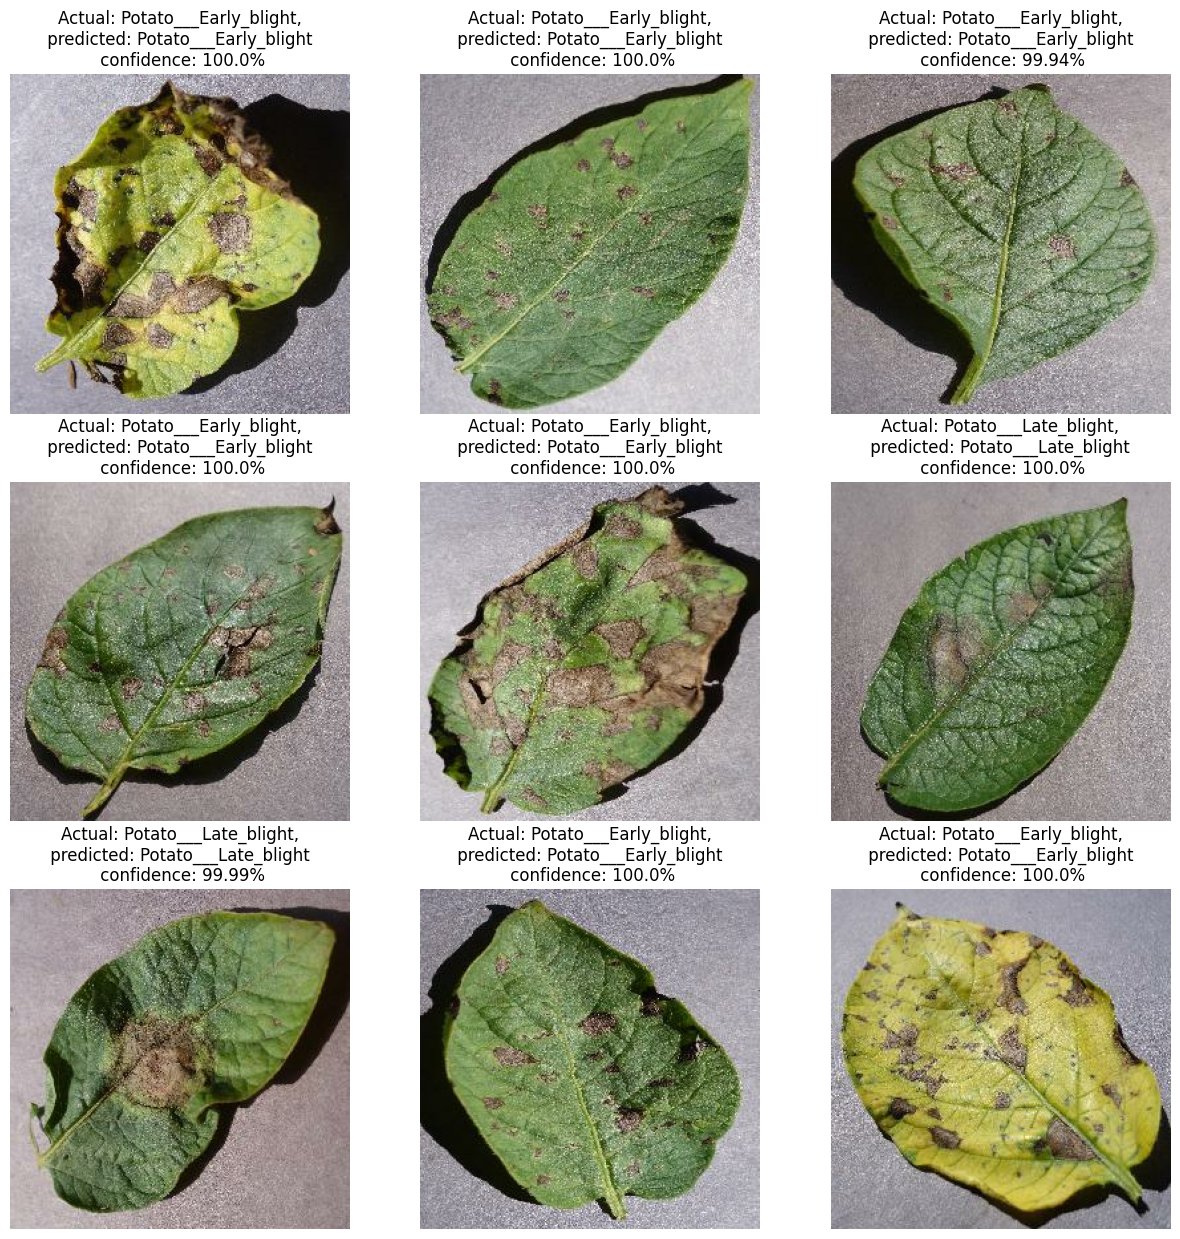

In [32]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):

  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    predicted_class,confidence=predict(model,images[i].numpy())

    actual_class=class_names[labels[i]]
    plt.title(f"Actual: {actual_class},\n predicted: {predicted_class} \n confidence: {confidence}%")
    plt.axis("off")